In [83]:
import sys
import os

parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
sys.path.append(parent_dir)

data_folder_path = os.path.abspath(os.path.join(os.getcwd(), os.pardir, "data_folder"))
sys.path.append(data_folder_path) 

from synth_dim_model import *
from paraparticle_utils import *

import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

import concurrent.futures
plt.rcParams.update({'font.size': 12})

from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import Normalize
np.set_printoptions(precision=5, suppress=True, linewidth=100)


<Token var=<ContextVar name='format_options' default={'edgeitems': 3, 'threshold': 1000, 'floatmode': 'maxprec', 'precision': 8, 'suppress': False, 'linewidth': 75, 'nanstr': 'nan', 'infstr': 'inf', 'sign': '-', 'formatter': None, 'legacy': 9223372036854775807, 'override_repr': None} at 0x000001E9B337E930> at 0x000001E9D187BDC0>

In [84]:
# my goal is to prepare two paraparticle states (localized paraparticles, not momentum mode paraparticles)

In [115]:
N = 5
M = 3
V = 1

states, formatted_states = enumerate_states(N, M)

"""psi_plus_first_site = build_paraparticle_operator(N, site_index = 3, alpha = 1, sign = "+")
psi_plus_second_site = build_paraparticle_operator(N, site_index = N, alpha = 1, sign = "+")"""

H = construct_hamiltonian(N, M, V = 1, mu = 0, J = 0)
eigenvalues, eigenvectors = exact_diagonalize(H)

number_op = construct_total_paraparticle_number_operator(N)

for i, state in enumerate(eigenvectors):
    if state.conj().T @ number_op @ state == 0j:
        print(f"state {i} has zero paraparticles")
        paraparticle_vacuum = state

state 121 has zero paraparticles


In [116]:
print("paraparticle vacuum =")
for i in range(len(states)):
    if paraparticle_vacuum[i] != 0:
        print(f"{paraparticle_vacuum[i]}: {formatted_states[i]} with E = {eigenvalues[i]}")

paraparticle vacuum =
(1+0j): |1,1,1,1,1> with E = 0.0


In [117]:
one_paraparticle_state =  build_paraparticle_operator(N, site_index = 1, alpha = 1, sign = "+") @ paraparticle_vacuum
print(f"check: number of paraparticles: {one_paraparticle_state.conj().T @ number_op @ one_paraparticle_state}")
print("one paraparticle at site 1 (flavor 1) = ")
for i in range(len(states)):
    if one_paraparticle_state[i] != 0:
        print(f"{one_paraparticle_state[i]}: {formatted_states[i]}")

check: number of paraparticles: (1+0j)
one paraparticle at site 1 (flavor 1) = 
(1+0j): |2,1,1,1,1>


In [118]:
two_paraparticle_state = build_paraparticle_operator(N, site_index = 1, alpha = 1, sign = "+") @ build_paraparticle_operator(N, site_index = 3, alpha = 2, sign = "+") @ paraparticle_vacuum
print(f"check: number of paraparticles: {two_paraparticle_state.conj().T @ number_op @ two_paraparticle_state}")

print(f"two paraparticles at site 1 (flavor 1) and site 3 (flavor 2) =  ")
for i in range(len(states)):
    if two_paraparticle_state[i] != 0:
        print(f"{two_paraparticle_state[i]}: {formatted_states[i]}")

check: number of paraparticles: (2+0j)
two paraparticles at site 1 (flavor 1) and site 3 (flavor 2) =  
(1+0j): |2,1,0,1,1>


In [119]:
two_paraparticle_state = build_paraparticle_operator(N, site_index = 1, alpha = 1, sign = "+") @ build_paraparticle_operator(N, site_index = N, alpha = 1, sign = "+") @ paraparticle_vacuum
print(f"check: number of paraparticles: {two_paraparticle_state.conj().T @ number_op @ two_paraparticle_state}")

print(f"two paraparticles at site 1 (flavor 1) and site {N} (flavor 1) =  ")
for i in range(len(states)):
    if two_paraparticle_state[i] != 0:
        print(f"{two_paraparticle_state[i]}: {formatted_states[i]}")

check: number of paraparticles: (2+0j)
two paraparticles at site 1 (flavor 1) and site 5 (flavor 1) =  
(1+0j): |2,1,1,1,2>


In [120]:
"""# first, let's look at the dynamics of a single paraparticle

times = np.linspace(0, 25, 500)

# Precompute site number operators
site_ops = [construct_site_paraparticle_number_operator(N, site_index=i+1) for i in range(N)]

# one paraparticle state

one_paraparticle_state =  build_paraparticle_operator(N, site_index = 1, alpha = 1, sign = "+") @ paraparticle_vacuum

# Time evolution
hamiltonians = [H for _ in times]
_, time_evolved_wavefunctions, *_ = simulate_hamiltonian_time_evolution(
    hamiltonians, times, initial_state=one_paraparticle_state
)

# Compute expectation values
expectation_data = np.zeros((len(times), N))  # rows: time, cols: sites

for t_idx, psi in enumerate(time_evolved_wavefunctions):
    for site_idx, op in enumerate(site_ops):
        expectation_data[t_idx, site_idx] = np.real(psi.conj().T @ op @ psi)

# Plot using imshow
plt.figure(figsize=(6, 6))
plt.imshow(expectation_data, aspect='auto', origin='lower', 
           extent=[1, N, times[0], times[-1]], cmap='viridis')

plt.colorbar(label=r'$\langle n_i \rangle$')
plt.xlabel('Site index $i$')
plt.ylabel('Time $t$')
plt.title(r'$\langle n_i(t) \rangle$ heatmap')
plt.show()
"""

'# first, let\'s look at the dynamics of a single paraparticle\n\ntimes = np.linspace(0, 25, 500)\n\n# Precompute site number operators\nsite_ops = [construct_site_paraparticle_number_operator(N, site_index=i+1) for i in range(N)]\n\n# one paraparticle state\n\none_paraparticle_state =  build_paraparticle_operator(N, site_index = 1, alpha = 1, sign = "+") @ paraparticle_vacuum\n\n# Time evolution\nhamiltonians = [H for _ in times]\n_, time_evolved_wavefunctions, *_ = simulate_hamiltonian_time_evolution(\n    hamiltonians, times, initial_state=one_paraparticle_state\n)\n\n# Compute expectation values\nexpectation_data = np.zeros((len(times), N))  # rows: time, cols: sites\n\nfor t_idx, psi in enumerate(time_evolved_wavefunctions):\n    for site_idx, op in enumerate(site_ops):\n        expectation_data[t_idx, site_idx] = np.real(psi.conj().T @ op @ psi)\n\n# Plot using imshow\nplt.figure(figsize=(6, 6))\nplt.imshow(expectation_data, aspect=\'auto\', origin=\'lower\', \n           extent=

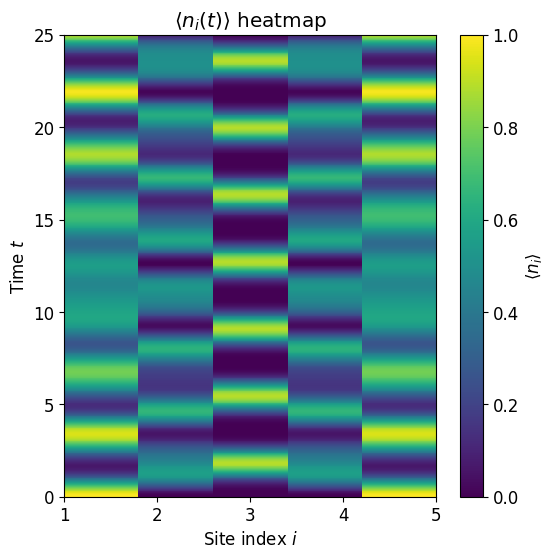

In [179]:
# now lets do it with two paraparticles

times = np.linspace(0, 25, 500)
site_ops = [construct_site_paraparticle_number_operator(N, site_index=i+1) for i in range(N)]

two_paraparticle_state = build_paraparticle_operator(N, site_index = 1, alpha = 1, sign = "+") @ build_paraparticle_operator(N, site_index = N, alpha = 1, sign = "+") @ paraparticle_vacuum

hamiltonians = [H for _ in times]
_, time_evolved_wavefunctions, *_ = simulate_hamiltonian_time_evolution(
    hamiltonians, times, initial_state=two_paraparticle_state
)

# Compute expectation values
expectation_data = np.zeros((len(times), N))  # rows: time, cols: sites

for t_idx, psi in enumerate(time_evolved_wavefunctions):
    for site_idx, op in enumerate(site_ops):
        expectation_data[t_idx, site_idx] = np.real(psi.conj().T @ op @ psi)

# Plot using imshow
plt.figure(figsize=(6, 6))
plt.imshow(expectation_data, aspect='auto', origin='lower', 
           extent=[1, N, times[0], times[-1]], cmap='viridis', interpolation = "none")

plt.colorbar(label=r'$\langle n_i \rangle$')
plt.xlabel('Site index $i$')
plt.ylabel('Time $t$')
plt.title(r'$\langle n_i(t) \rangle$ heatmap')
plt.show()

In [122]:
def construct_single_site_number_operator(N, M, site_index, synth_level, states):
    dim = M**N
    number_operator_matrix = np.zeros((dim, dim), dtype=np.complex128)
    
    for k in range(dim):
        if states[k][site_index] == synth_level:
            number_operator_matrix[k,k] = 1
             
    return number_operator_matrix

In [205]:
# now, what changes if we look at synthetic site occupancy for two paraparticles?

times = np.linspace(0, 25, 100)
# Precompute site number operators
site_ops = [construct_single_site_number_operator(N, M = 3, site_index = i, synth_level = 0, states = states)  for i in range(N)]

# two paraparticle state

two_paraparticle_state = build_paraparticle_operator(N, site_index = 1, alpha = 1, sign = "+") @ build_paraparticle_operator(N, site_index = N, alpha = 2, sign = "+") @ paraparticle_vacuum

hamiltonians = [H for _ in times]
_, time_evolved_wavefunctions, *_ = simulate_hamiltonian_time_evolution(
    hamiltonians, times, initial_state=two_paraparticle_state
)

# Compute expectation values
expectation_data_0 = np.zeros((len(times), N))  # rows: time, cols: sites

for t_idx, psi in enumerate(time_evolved_wavefunctions):
    for site_idx, op in enumerate(site_ops):
        expectation_data_0[t_idx, site_idx] = np.real(psi.conj().T @ op @ psi)

"""# Plot using imshow
plt.figure(figsize=(6, 6))
plt.imshow(expectation_data_0, aspect='auto', origin='lower', 
           extent=[1, N, times[0], times[-1]], cmap='Blues', interpolation = "none")

plt.colorbar(label=r'$\langle n_{0,i} \rangle$')
plt.xlabel('Site index $i$')
plt.ylabel('Time $t$')
plt.title(r'$\langle n_{0,i}(t) \rangle$ heatmap')
plt.show()"""


'# Plot using imshow\nplt.figure(figsize=(6, 6))\nplt.imshow(expectation_data_0, aspect=\'auto\', origin=\'lower\', \n           extent=[1, N, times[0], times[-1]], cmap=\'Blues\', interpolation = "none")\n\nplt.colorbar(label=r\'$\\langle n_{0,i} \rangle$\')\nplt.xlabel(\'Site index $i$\')\nplt.ylabel(\'Time $t$\')\nplt.title(r\'$\\langle n_{0,i}(t) \rangle$ heatmap\')\nplt.show()'

In [203]:
# now, what changes if we look at synthetic site occupancy for two paraparticles?

times = np.linspace(0, 25, 100)
# Precompute site number operators
site_ops = [construct_single_site_number_operator(N, M = 3, site_index = i, synth_level = 2, states = states)  for i in range(N)]

# two paraparticle state

two_paraparticle_state = build_paraparticle_operator(N, site_index = 1, alpha = 1, sign = "+") @ build_paraparticle_operator(N, site_index = N, alpha = 2, sign = "+") @ paraparticle_vacuum

hamiltonians = [H for _ in times]
_, time_evolved_wavefunctions, *_ = simulate_hamiltonian_time_evolution(
    hamiltonians, times, initial_state=two_paraparticle_state
)

# Compute expectation values
expectation_data_2 = np.zeros((len(times), N))  # rows: time, cols: sites

for t_idx, psi in enumerate(time_evolved_wavefunctions):
    for site_idx, op in enumerate(site_ops):
        expectation_data_2[t_idx, site_idx] = np.real(psi.conj().T @ op @ psi)

"""# Plot using imshow
plt.figure(figsize=(6, 6))
plt.imshow(expectation_data_2, aspect='auto', origin='lower', 
           extent=[1, N, times[0], times[-1]], cmap='Reds', interpolation = "none")

plt.colorbar(label=r'$\langle n_{2,i} \rangle$')
plt.xlabel('Site index $i$')
plt.ylabel('Time $t$')
plt.title(r'$\langle n_{2,i}(t) \rangle$ heatmap')
plt.show()"""


'# Plot using imshow\nplt.figure(figsize=(6, 6))\nplt.imshow(expectation_data_2, aspect=\'auto\', origin=\'lower\', \n           extent=[1, N, times[0], times[-1]], cmap=\'Reds\', interpolation = "none")\n\nplt.colorbar(label=r\'$\\langle n_{2,i} \rangle$\')\nplt.xlabel(\'Site index $i$\')\nplt.ylabel(\'Time $t$\')\nplt.title(r\'$\\langle n_{2,i}(t) \rangle$ heatmap\')\nplt.show()'

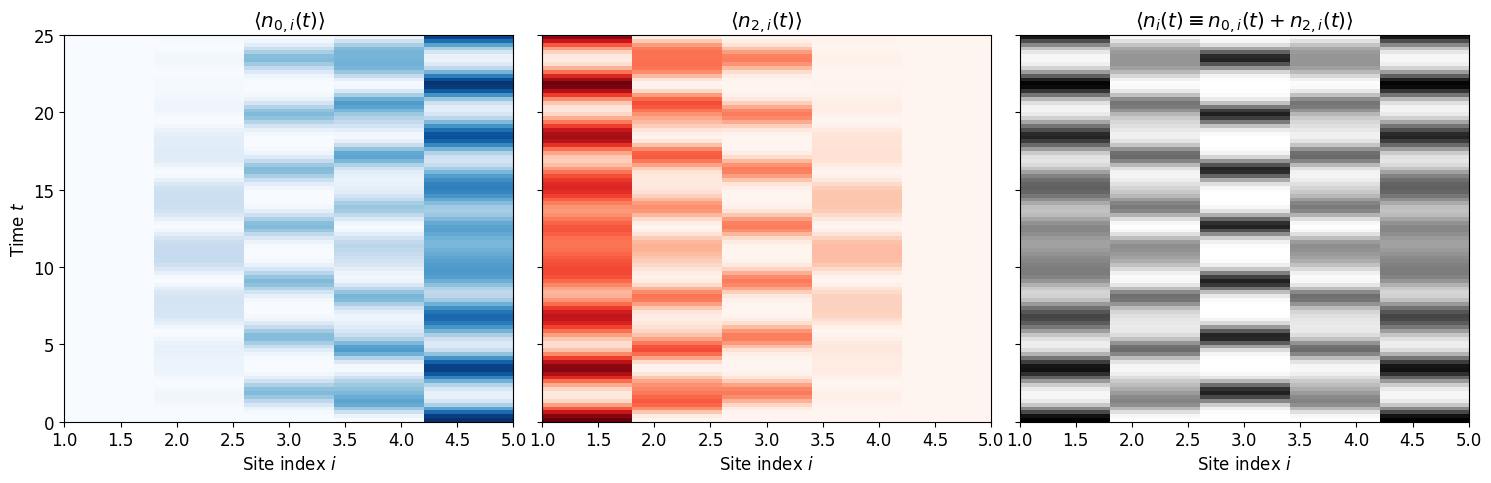

In [206]:
fig, (ax1, ax2, ax3) = plt.subplots(figsize=(15, 5), ncols=3, sharey=True)

im1 = ax1.imshow(expectation_data_0, aspect='auto', origin='lower', 
                 extent=[1, N, times[0], times[-1]], cmap='Blues', interpolation="none")
ax1.set_xlabel('Site index $i$')
ax1.set_ylabel('Time $t$')
ax1.set_title(r'$\langle n_{0,i}(t) \rangle$')



im2 = ax2.imshow(expectation_data_2, aspect='auto', origin='lower', 
                 extent=[1, N, times[0], times[-1]], cmap='Reds', interpolation="none")
ax2.set_xlabel('Site index $i$')
ax2.set_title(r'$\langle n_{2,i}(t) \rangle$')

im3 = ax3.imshow(expectation_data_0 + expectation_data_2, aspect='auto', origin='lower', 
                 extent=[1, N, times[0], times[-1]], cmap='Grays', interpolation="none")
ax3.set_xlabel('Site index $i$')
ax3.set_title(r'$\langle n_{i}(t) \equiv n_{0,i}(t) + n_{2,i}(t) \rangle$')

plt.tight_layout()
plt.show()

In [94]:
"""# now, what changes if we look at synthetic site occupancy for two paraparticles?

times = np.linspace(0, 25, 500)
# Precompute site number operators
site_ops = [construct_single_site_number_operator(N, M = 3, site_index = i, synth_level = 1, states = states)  for i in range(N)]

# one paraparticle state

two_paraparticle_state = build_paraparticle_operator(N, site_index = 1, alpha = 1, sign = "+") @ build_paraparticle_operator(N, site_index = N, alpha = 2, sign = "+") @ paraparticle_vacuum

hamiltonians = [H for _ in times]
_, time_evolved_wavefunctions, *_ = simulate_hamiltonian_time_evolution(
    hamiltonians, times, initial_state=two_paraparticle_state
)

# Compute expectation values
expectation_data = np.zeros((len(times), N))  # rows: time, cols: sites

for t_idx, psi in enumerate(time_evolved_wavefunctions):
    for site_idx, op in enumerate(site_ops):
        expectation_data[t_idx, site_idx] = np.real(psi.conj().T @ op @ psi)

# Plot using imshow
plt.figure(figsize=(6, 6))
plt.imshow(expectation_data, aspect='auto', origin='lower', 
           extent=[1, N, times[0], times[-1]], cmap='viridis')

plt.colorbar(label=r'$\langle n_{1,i} \rangle$')
plt.xlabel('Site index $i$')
plt.ylabel('Time $t$')
plt.title(r'$\langle n_{1,i}(t) \rangle$ heatmap')
plt.show()
"""

'# now, what changes if we look at synthetic site occupancy for two paraparticles?\n\ntimes = np.linspace(0, 25, 500)\n# Precompute site number operators\nsite_ops = [construct_single_site_number_operator(N, M = 3, site_index = i, synth_level = 1, states = states)  for i in range(N)]\n\n# one paraparticle state\n\ntwo_paraparticle_state = build_paraparticle_operator(N, site_index = 1, alpha = 1, sign = "+") @ build_paraparticle_operator(N, site_index = N, alpha = 2, sign = "+") @ paraparticle_vacuum\n\nhamiltonians = [H for _ in times]\n_, time_evolved_wavefunctions, *_ = simulate_hamiltonian_time_evolution(\n    hamiltonians, times, initial_state=two_paraparticle_state\n)\n\n# Compute expectation values\nexpectation_data = np.zeros((len(times), N))  # rows: time, cols: sites\n\nfor t_idx, psi in enumerate(time_evolved_wavefunctions):\n    for site_idx, op in enumerate(site_ops):\n        expectation_data[t_idx, site_idx] = np.real(psi.conj().T @ op @ psi)\n\n# Plot using imshow\nplt.f

In [95]:
"""# now, what changes if we look at synthetic site occupancy for two paraparticles?

times = np.linspace(0, 25, 500)
# Precompute site number operators
site_ops = [construct_single_site_number_operator(N, M = 3, site_index = i, synth_level = 2, states = states)  for i in range(N)]

# one paraparticle state

two_paraparticle_state = build_paraparticle_operator(N, site_index = 1, alpha = 1, sign = "+") @ build_paraparticle_operator(N, site_index = N, alpha = 2, sign = "+") @ paraparticle_vacuum

hamiltonians = [H for _ in times]
_, time_evolved_wavefunctions, *_ = simulate_hamiltonian_time_evolution(
    hamiltonians, times, initial_state=two_paraparticle_state
)

# Compute expectation values
expectation_data = np.zeros((len(times), N))  # rows: time, cols: sites

for t_idx, psi in enumerate(time_evolved_wavefunctions):
    for site_idx, op in enumerate(site_ops):
        expectation_data[t_idx, site_idx] = np.real(psi.conj().T @ op @ psi)

# Plot using imshow
plt.figure(figsize=(6, 6))
plt.imshow(expectation_data, aspect='auto', origin='lower', 
           extent=[1, N, times[0], times[-1]], cmap='viridis')

plt.colorbar(label=r'$\langle n_{2,i} \rangle$')
plt.xlabel('Site index $i$')
plt.ylabel('Time $t$')
plt.title(r'$\langle n_{2,i}(t) \rangle$ heatmap')
plt.show()
"""

'# now, what changes if we look at synthetic site occupancy for two paraparticles?\n\ntimes = np.linspace(0, 25, 500)\n# Precompute site number operators\nsite_ops = [construct_single_site_number_operator(N, M = 3, site_index = i, synth_level = 2, states = states)  for i in range(N)]\n\n# one paraparticle state\n\ntwo_paraparticle_state = build_paraparticle_operator(N, site_index = 1, alpha = 1, sign = "+") @ build_paraparticle_operator(N, site_index = N, alpha = 2, sign = "+") @ paraparticle_vacuum\n\nhamiltonians = [H for _ in times]\n_, time_evolved_wavefunctions, *_ = simulate_hamiltonian_time_evolution(\n    hamiltonians, times, initial_state=two_paraparticle_state\n)\n\n# Compute expectation values\nexpectation_data = np.zeros((len(times), N))  # rows: time, cols: sites\n\nfor t_idx, psi in enumerate(time_evolved_wavefunctions):\n    for site_idx, op in enumerate(site_ops):\n        expectation_data[t_idx, site_idx] = np.real(psi.conj().T @ op @ psi)\n\n# Plot using imshow\nplt.f

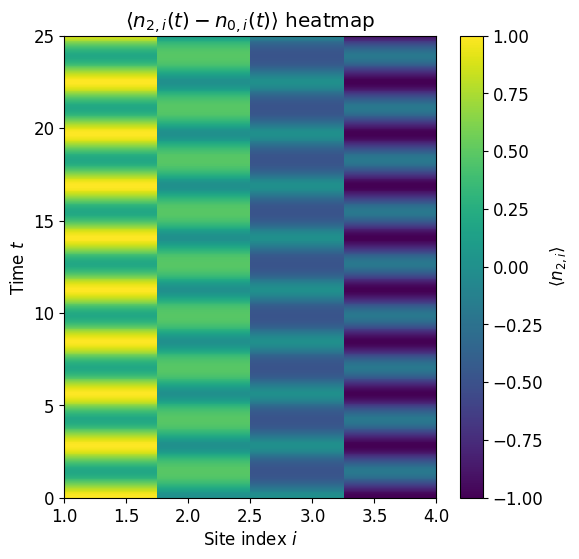

In [96]:
# now, what changes if we look at magnetization n_2 - n_1

times = np.linspace(0, 25, 500)
# Precompute site number operators
site_ops = [construct_single_site_number_operator(N, M = 3, site_index = i, synth_level = 2, states = states) - construct_single_site_number_operator(N, M = 3, site_index = i, synth_level = 0, states = states)  for i in range(N)]

# two paraparticle state

two_paraparticle_state = build_paraparticle_operator(N, site_index = 1, alpha = 1, sign = "+") @ build_paraparticle_operator(N, site_index = N, alpha = 2, sign = "+") @ paraparticle_vacuum

hamiltonians = [H for _ in times]
_, time_evolved_wavefunctions, *_ = simulate_hamiltonian_time_evolution(
    hamiltonians, times, initial_state=two_paraparticle_state
)

# Compute expectation values
expectation_data = np.zeros((len(times), N))  # rows: time, cols: sites

for t_idx, psi in enumerate(time_evolved_wavefunctions):
    for site_idx, op in enumerate(site_ops):
        expectation_data[t_idx, site_idx] = np.real(psi.conj().T @ op @ psi)

# Plot using imshow
plt.figure(figsize=(6, 6))
plt.imshow(expectation_data, aspect='auto', origin='lower', 
           extent=[1, N, times[0], times[-1]], cmap='viridis', interpolation = "none")

plt.colorbar(label=r'$\langle n_{2,i} \rangle$')
plt.xlabel('Site index $i$')
plt.ylabel('Time $t$')
plt.title(r'$\langle n_{2,i}(t) - n_{0,i}(t) \rangle$ heatmap')
plt.show()


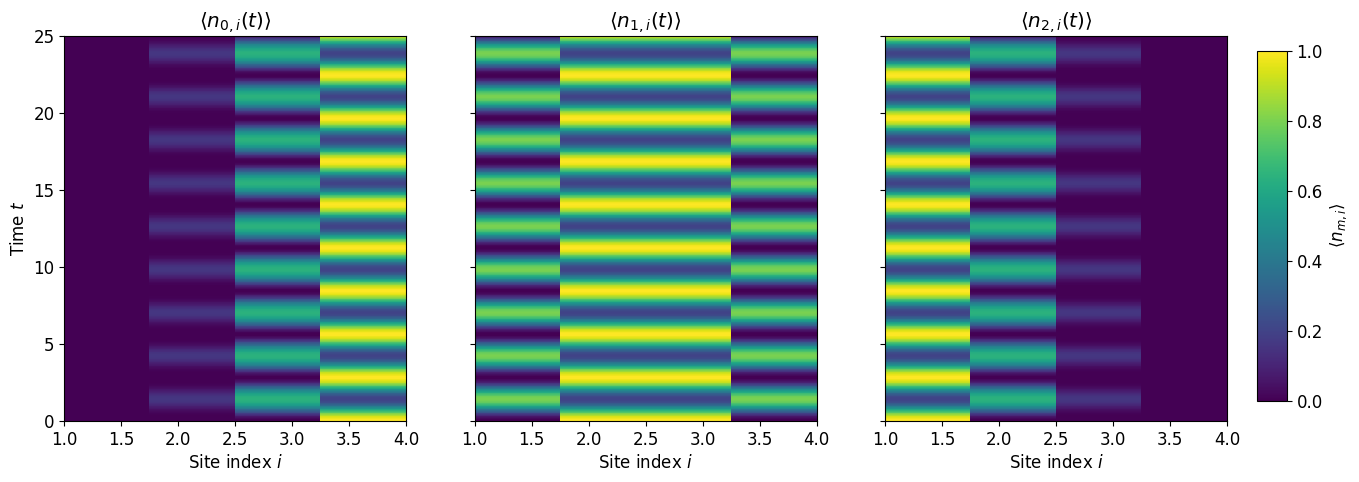

In [106]:
times = np.linspace(0, 25, 500)
synth_levels = [0, 1, 2]
titles = [r'$\langle n_{0,i}(t) \rangle$', r'$\langle n_{1,i}(t) \rangle$', r'$\langle n_{2,i}(t) \rangle$']

fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

im = None

for idx, synth_level in enumerate(synth_levels):
    site_ops = [construct_single_site_number_operator(N, M=3, site_index=i, synth_level=synth_level, states=states) for i in range(N)]

    two_paraparticle_state = build_paraparticle_operator(N, site_index=1, alpha=1, sign="+") @ \
                             build_paraparticle_operator(N, site_index=N, alpha=2, sign="+") @ paraparticle_vacuum

    hamiltonians = [H for _ in times]
    _, time_evolved_wavefunctions, *_ = simulate_hamiltonian_time_evolution(
        hamiltonians, times, initial_state=two_paraparticle_state
    )

    expectation_data = np.zeros((len(times), N))
    for t_idx, psi in enumerate(time_evolved_wavefunctions):
        for site_idx, op in enumerate(site_ops):
            expectation_data[t_idx, site_idx] = np.real(psi.conj().T @ op @ psi)

    im = axes[idx].imshow(
    expectation_data,
    aspect='auto',
    origin='lower',
    extent=[1, N, times[0], times[-1]],
    cmap='viridis',
    interpolation='none'
)

    axes[idx].set_title(titles[idx])
    axes[idx].set_xlabel('Site index $i$')
    if idx == 0:
        axes[idx].set_ylabel('Time $t$')

cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  
fig.colorbar(im, cax=cbar_ax).set_label(r'$\langle n_{m, i} \rangle$')

plt.subplots_adjust(right=0.9)  
plt.show()


In [100]:
"""times = np.linspace(0, 25, 500)
synth_levels = [0, 2]
titles = [r'$\langle n_{0,i}(t) \rangle$', r'$\langle n_{1,i}(t) \rangle$', r'$\langle n_{2,i}(t) \rangle$']

fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

im = None

for idx, synth_level in enumerate(synth_levels):
    site_ops = [construct_single_site_number_operator(N, M=3, site_index=i, synth_level=synth_level, states=states) for i in range(N)]

    two_paraparticle_state = build_paraparticle_operator(N, site_index=1, alpha=1, sign="+") @ \
                             build_paraparticle_operator(N, site_index=N, alpha=2, sign="+") @ paraparticle_vacuum

    hamiltonians = [H for _ in times]
    _, time_evolved_wavefunctions, *_ = simulate_hamiltonian_time_evolution(
        hamiltonians, times, initial_state=two_paraparticle_state
    )

    expectation_data = np.zeros((len(times), N))
    for t_idx, psi in enumerate(time_evolved_wavefunctions):
        for site_idx, op in enumerate(site_ops):
            expectation_data[t_idx, site_idx] = np.real(psi.conj().T @ op @ psi)

    im = axes[idx].imshow(
    expectation_data,
    aspect='auto',
    origin='lower',
    extent=[1, N, times[0], times[-1]],
    cmap='viridis',
    interpolation='none'
)

    axes[idx].set_title(titles[idx])
    axes[idx].set_xlabel('Site index $i$')
    if idx == 0:
        axes[idx].set_ylabel('Time $t$')

cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  
fig.colorbar(im, cax=cbar_ax).set_label(r'$\langle n_{m, i} \rangle$')

plt.subplots_adjust(right=0.9)  
plt.show()
"""

'times = np.linspace(0, 25, 500)\nsynth_levels = [0, 2]\ntitles = [r\'$\\langle n_{0,i}(t) \rangle$\', r\'$\\langle n_{1,i}(t) \rangle$\', r\'$\\langle n_{2,i}(t) \rangle$\']\n\nfig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)\n\nim = None\n\nfor idx, synth_level in enumerate(synth_levels):\n    site_ops = [construct_single_site_number_operator(N, M=3, site_index=i, synth_level=synth_level, states=states) for i in range(N)]\n\n    two_paraparticle_state = build_paraparticle_operator(N, site_index=1, alpha=1, sign="+") @                              build_paraparticle_operator(N, site_index=N, alpha=2, sign="+") @ paraparticle_vacuum\n\n    hamiltonians = [H for _ in times]\n    _, time_evolved_wavefunctions, *_ = simulate_hamiltonian_time_evolution(\n        hamiltonians, times, initial_state=two_paraparticle_state\n    )\n\n    expectation_data = np.zeros((len(times), N))\n    for t_idx, psi in enumerate(time_evolved_wavefunctions):\n        for site_idx, op in enumerate(s

In [101]:
"""# what about three paraparticles?

times = np.linspace(0, 25, 500)
synth_levels = [0, 1, 2]
titles = [r'$\langle n_{0,i}(t) \rangle$', r'$\langle n_{1,i}(t) \rangle$', r'$\langle n_{2,i}(t) \rangle$']

fig, axes = plt.subplots(1, 3, figsize=(15, 6), sharey=True)

im = None

for idx, synth_level in enumerate(synth_levels):
    site_ops = [construct_single_site_number_operator(N, M=3, site_index=i, synth_level=synth_level, states=states) for i in range(N)]

    three_paraparticle_state = build_paraparticle_operator(N, site_index=1, alpha=1, sign="+") @ build_paraparticle_operator(N, site_index=N//2 + 1, alpha = 2, sign="+") @ \
                             build_paraparticle_operator(N, site_index=N, alpha=1, sign="+") @ paraparticle_vacuum

    hamiltonians = [H for _ in times]
    _, time_evolved_wavefunctions, *_ = simulate_hamiltonian_time_evolution(
        hamiltonians, times, initial_state=three_paraparticle_state
    )

    expectation_data = np.zeros((len(times), N))
    for t_idx, psi in enumerate(time_evolved_wavefunctions):
        for site_idx, op in enumerate(site_ops):
            expectation_data[t_idx, site_idx] = np.real(psi.conj().T @ op @ psi)

    im = axes[idx].imshow(
        expectation_data,
        aspect='auto',
        origin='lower',
        extent=[1, N, times[0], times[-1]],
        cmap='viridis'
    )
    axes[idx].set_title(titles[idx])
    axes[idx].set_xlabel('Site index $i$')
    if idx == 0:
        axes[idx].set_ylabel('Time $t$')

cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  
fig.colorbar(im, cax=cbar_ax).set_label(r'$\langle n_{m, i} \rangle$')

plt.subplots_adjust(right=0.9)  
plt.show()
"""

'# what about three paraparticles?\n\ntimes = np.linspace(0, 25, 500)\nsynth_levels = [0, 1, 2]\ntitles = [r\'$\\langle n_{0,i}(t) \rangle$\', r\'$\\langle n_{1,i}(t) \rangle$\', r\'$\\langle n_{2,i}(t) \rangle$\']\n\nfig, axes = plt.subplots(1, 3, figsize=(15, 6), sharey=True)\n\nim = None\n\nfor idx, synth_level in enumerate(synth_levels):\n    site_ops = [construct_single_site_number_operator(N, M=3, site_index=i, synth_level=synth_level, states=states) for i in range(N)]\n\n    three_paraparticle_state = build_paraparticle_operator(N, site_index=1, alpha=1, sign="+") @ build_paraparticle_operator(N, site_index=N//2 + 1, alpha = 2, sign="+") @                              build_paraparticle_operator(N, site_index=N, alpha=1, sign="+") @ paraparticle_vacuum\n\n    hamiltonians = [H for _ in times]\n    _, time_evolved_wavefunctions, *_ = simulate_hamiltonian_time_evolution(\n        hamiltonians, times, initial_state=three_paraparticle_state\n    )\n\n    expectation_data = np.zeros(

In [102]:
"""# delete me soon
times = np.linspace(0, 25, 500)

# Precompute site number operators
site_ops = [construct_site_paraparticle_number_operator(N, site_index=i+1) for i in range(N)]

# one paraparticle state

three_paraparticle_state = build_paraparticle_operator(N, site_index=1, alpha=1, sign="+") @ build_paraparticle_operator(N, site_index=N//2 + 1, alpha=2, sign="+") @ \
                             build_paraparticle_operator(N, site_index=N, alpha=1, sign="+") @ paraparticle_vacuum
# Time evolution
hamiltonians = [H for _ in times]
_, time_evolved_wavefunctions, *_ = simulate_hamiltonian_time_evolution(
    hamiltonians, times, initial_state=three_paraparticle_state
)

# Compute expectation values
expectation_data = np.zeros((len(times), N))  # rows: time, cols: sites

for t_idx, psi in enumerate(time_evolved_wavefunctions):
    for site_idx, op in enumerate(site_ops):
        expectation_data[t_idx, site_idx] = np.real(psi.conj().T @ op @ psi)

# Plot using imshow
plt.figure(figsize=(6, 6))
plt.imshow(expectation_data, aspect='auto', origin='lower', 
           extent=[1, N, times[0], times[-1]], cmap='viridis')

plt.colorbar(label=r'$\langle n_i \rangle$')
plt.xlabel('Site index $i$')
plt.ylabel('Time $t$')
plt.title(r'$\langle n_i(t) \rangle$ heatmap')
plt.show()
"""

'# delete me soon\ntimes = np.linspace(0, 25, 500)\n\n# Precompute site number operators\nsite_ops = [construct_site_paraparticle_number_operator(N, site_index=i+1) for i in range(N)]\n\n# one paraparticle state\n\nthree_paraparticle_state = build_paraparticle_operator(N, site_index=1, alpha=1, sign="+") @ build_paraparticle_operator(N, site_index=N//2 + 1, alpha=2, sign="+") @                              build_paraparticle_operator(N, site_index=N, alpha=1, sign="+") @ paraparticle_vacuum\n# Time evolution\nhamiltonians = [H for _ in times]\n_, time_evolved_wavefunctions, *_ = simulate_hamiltonian_time_evolution(\n    hamiltonians, times, initial_state=three_paraparticle_state\n)\n\n# Compute expectation values\nexpectation_data = np.zeros((len(times), N))  # rows: time, cols: sites\n\nfor t_idx, psi in enumerate(time_evolved_wavefunctions):\n    for site_idx, op in enumerate(site_ops):\n        expectation_data[t_idx, site_idx] = np.real(psi.conj().T @ op @ psi)\n\n# Plot using imsh

In [103]:
"""print(f"check: number of paraparticles: {three_paraparticle_state.conj().T @ number_op @ three_paraparticle_state}")

print(f"two paraparticles at site 1 (flavor 1) and site {N} (flavor 1) =  ")
for i in range(len(states)):
    if three_paraparticle_state[i] != 0:
        print(f"{three_paraparticle_state[i]}: {formatted_states[i]}")"""

'print(f"check: number of paraparticles: {three_paraparticle_state.conj().T @ number_op @ three_paraparticle_state}")\n\nprint(f"two paraparticles at site 1 (flavor 1) and site {N} (flavor 1) =  ")\nfor i in range(len(states)):\n    if three_paraparticle_state[i] != 0:\n        print(f"{three_paraparticle_state[i]}: {formatted_states[i]}")'

In [104]:
"""# what about three paraparticles?

times = np.linspace(0, 25, 500)
synth_levels = [0, 1, 2]
titles = [r'$\langle n_{0,i}(t) \rangle$', r'$\langle n_{1,i}(t) \rangle$', r'$\langle n_{2,i}(t) \rangle$']

fig, axes = plt.subplots(1, 3, figsize=(15, 6), sharey=True)

im = None

for idx, synth_level in enumerate(synth_levels):
    site_ops = [construct_single_site_number_operator(N, M=3, site_index=i, synth_level=synth_level, states=states) for i in range(N)]

    two_paraparticle_state = build_paraparticle_operator(N, site_index = 1, alpha = 1, sign="+") @ \
                             build_paraparticle_operator(N, site_index = N, alpha = 1, sign="+") @ paraparticle_vacuum

    hamiltonians = [H for _ in times]
    _, time_evolved_wavefunctions, *_ = simulate_hamiltonian_time_evolution(
        hamiltonians, times, initial_state=two_paraparticle_state
    )

    expectation_data = np.zeros((len(times), N))
    for t_idx, psi in enumerate(time_evolved_wavefunctions):
        for site_idx, op in enumerate(site_ops):
            expectation_data[t_idx, site_idx] = np.real(psi.conj().T @ op @ psi)

    im = axes[idx].imshow(
        expectation_data,
        aspect='auto',
        origin='lower',
        extent=[1, N, times[0], times[-1]],
        cmap='viridis'
    )
    axes[idx].set_title(titles[idx])
    axes[idx].set_xlabel('Site index $i$')
    if idx == 0:
        axes[idx].set_ylabel('Time $t$')

cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  
fig.colorbar(im, cax=cbar_ax).set_label(r'$\langle n_{m, i} \rangle$')

plt.subplots_adjust(right=0.9)  
plt.show()"""


'# what about three paraparticles?\n\ntimes = np.linspace(0, 25, 500)\nsynth_levels = [0, 1, 2]\ntitles = [r\'$\\langle n_{0,i}(t) \rangle$\', r\'$\\langle n_{1,i}(t) \rangle$\', r\'$\\langle n_{2,i}(t) \rangle$\']\n\nfig, axes = plt.subplots(1, 3, figsize=(15, 6), sharey=True)\n\nim = None\n\nfor idx, synth_level in enumerate(synth_levels):\n    site_ops = [construct_single_site_number_operator(N, M=3, site_index=i, synth_level=synth_level, states=states) for i in range(N)]\n\n    two_paraparticle_state = build_paraparticle_operator(N, site_index = 1, alpha = 1, sign="+") @                              build_paraparticle_operator(N, site_index = N, alpha = 1, sign="+") @ paraparticle_vacuum\n\n    hamiltonians = [H for _ in times]\n    _, time_evolved_wavefunctions, *_ = simulate_hamiltonian_time_evolution(\n        hamiltonians, times, initial_state=two_paraparticle_state\n    )\n\n    expectation_data = np.zeros((len(times), N))\n    for t_idx, psi in enumerate(time_evolved_wavefunc

In [105]:
"""# Evolve system
times = np.linspace(0, 25, 500)
hamiltonians = [H for _ in times]
_, time_evolved_wavefunctions, *_ = simulate_hamiltonian_time_evolution(
    hamiltonians, times, initial_state=two_paraparticle_state
)

# Prepare subplots
fig, axes = plt.subplots(nrows=N, sharex=True, figsize=(6, 3*N))

# Handle case where num_sites = 1 (axes is not a list)
if N == 1:
    axes = [axes]

# Plot expectation values
for site_idx in range(N):
    op = site_ops[site_idx]
    exp_values = [
        np.real(state.conj().T @ op @ state)
        for state in time_evolved_wavefunctions
    ]
    axes[site_idx].plot(times, exp_values, '.-')
    axes[site_idx].set_ylabel(rf"$\langle n_{site_idx+1} \rangle$")
    axes[site_idx].set_title(rf"Site {site_idx+1}")

axes[-1].set_xlabel(r"Time $t$")
fig.tight_layout()
plt.show()
"""

'# Evolve system\ntimes = np.linspace(0, 25, 500)\nhamiltonians = [H for _ in times]\n_, time_evolved_wavefunctions, *_ = simulate_hamiltonian_time_evolution(\n    hamiltonians, times, initial_state=two_paraparticle_state\n)\n\n# Prepare subplots\nfig, axes = plt.subplots(nrows=N, sharex=True, figsize=(6, 3*N))\n\n# Handle case where num_sites = 1 (axes is not a list)\nif N == 1:\n    axes = [axes]\n\n# Plot expectation values\nfor site_idx in range(N):\n    op = site_ops[site_idx]\n    exp_values = [\n        np.real(state.conj().T @ op @ state)\n        for state in time_evolved_wavefunctions\n    ]\n    axes[site_idx].plot(times, exp_values, \'.-\')\n    axes[site_idx].set_ylabel(rf"$\\langle n_{site_idx+1} \rangle$")\n    axes[site_idx].set_title(rf"Site {site_idx+1}")\n\naxes[-1].set_xlabel(r"Time $t$")\nfig.tight_layout()\nplt.show()\n'